In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import r_regression
from scipy.stats import pearsonr

import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


In [3]:

def get_by_char(char='R', num=3):
    return pd.read_csv(f'./{char}/{char}_chunks_{num}.csv')

In [4]:
df_r = get_by_char('R')
df_g = get_by_char('G')

In [5]:
x = df_g.iloc[:, 0:60].to_numpy()
y = df_g.iloc[:,61].to_numpy()

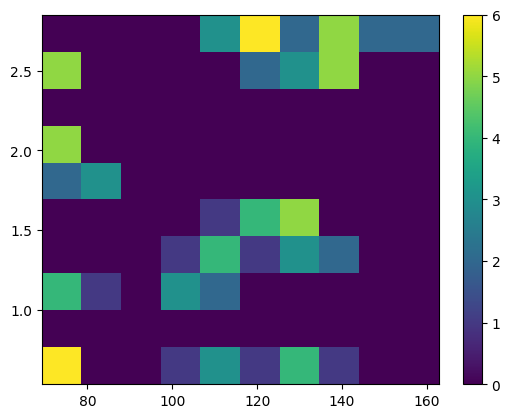

In [6]:
plt.hist2d(np.mean(x, axis=1), y, bins=10)
plt.colorbar()
plt.show()

In [7]:
r_regression(np.max(x, axis=1).reshape(-1,1), y)

array([0.33188741])

In [8]:

xs = []
ys = []
for p in range(3, 13):
    df_g = get_by_char('G', p)
    df_r = get_by_char('R', p)
    df_b = get_by_char('B', p)

    x = np.concat([np.nan_to_num(np.expand_dims(df_r.iloc[:, 0:60].to_numpy(), axis=2)),
                   np.nan_to_num(np.expand_dims(df_g.iloc[:, 0:60].to_numpy(), axis=2)),
                   np.nan_to_num(np.expand_dims(df_b.iloc[:, 0:60].to_numpy(), axis=2))], axis=2)
    y = np.nan_to_num(df_g.iloc[:, 61].to_numpy(), nan=0.)
    
    xs.append(x)
    ys.append(y)
    
    

In [ ]:
import torch
import torch.nn as nn

class RegressionLSTM(nn.Module):
    def __init__(self, input_size=3, second_hidden=64, minute_hidden=128, dropout=0.1):
        super().__init__()
        self.local_lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=second_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        self.global_lstm = nn.LSTM(
            input_size=second_hidden,
            hidden_size=minute_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )

        self.fc = nn.Sequential(
            nn.Linear(minute_hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        
        _, (h_sec, _) = self.local_lstm(x)   
        minute_emb = h_sec[-1]               

        
        out, _ = self.global_lstm(minute_emb.unsqueeze(0))  
        y_pred = self.fc(out.squeeze(0)).squeeze(-1)        

        return y_pred
    
def compute_metrics(y_pred, y_true):
    mae = torch.sum(torch.abs(y_pred - y_true)).item()
    rmse = torch.sqrt(torch.sum((y_pred - y_true) ** 2)).item()
    y_mean = torch.mean(y_true)
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = (1 - ss_res / ss_tot).item()
    
    return mae, rmse, r2

In [ ]:
model = RegressionLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss(reduction='none')  

from sklearn.model_selection import train_test_split


x_list = [torch.tensor(x,dtype=torch.float) for x in xs]
y_list = [torch.tensor(y, dtype=torch.float) for y in ys]

x_train,  x_test, y_train, y_test = train_test_split(x_list, y_list, test_size=0.2) 


criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

t = ()
for epoch in range(500):
    total_loss = 0.
    total_mae = 0.
    total_rmse = 0.
    total_r2 = 0.
    for x, y in zip(x_train, y_train):
        optimizer.zero_grad()
        y_pred = model(x)          
        
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        mae, rmse, r2 = compute_metrics(y_pred, y)
        total_mae += mae
        total_rmse += rmse
        total_r2 += r2

    if epoch == 0 or epoch % 10 == 0:
        n = len(x_list)
        avg_loss = total_loss / n
        avg_mae = total_mae / n
        avg_rmse = total_rmse / n
        avg_r2 = total_r2 / n
        print(f"Epoch {epoch:02d}")
        print(f"Train metrics | Loss={avg_loss:.6f} | MAE={avg_mae:.6f} | RMSE={avg_rmse:.6f} | R2={avg_r2:.6f}")
        
        with torch.no_grad():
            total_mae, total_rmse, total_r2 = 0.0, 0.0, 0.0
            for x, y in zip(x_test, y_test):
                y_pred = model(x)
                mae, rmse, r2 = compute_metrics(y_pred, y)
                total_mae += mae
                total_rmse += rmse
                total_r2 += r2

            n = len(x_test)
            avg_mae = total_mae / n
            avg_rmse = total_rmse / n
            avg_r2 = total_r2 / n
        print(f"Test set metrics: \t\t| MAE={avg_mae:.6f} | RMSE={avg_rmse:.6f} | R2={avg_r2:.6f}")
        print()

Epoch 00
Train metrics | Loss=267.755670 | MAE=129.928985 | RMSE=13.571095 | R2=-3.994293
Test set metrics: 		| MAE=171.773750 | RMSE=17.551328 | R2=-2.999104

Epoch 10
Train metrics | Loss=82.325220 | MAE=70.572563 | RMSE=7.916414 | R2=-1.801438
Test set metrics: 		| MAE=85.858089 | RMSE=8.834299 | R2=-0.018596

Epoch 20
Train metrics | Loss=63.017132 | MAE=60.659158 | RMSE=6.957519 | R2=-2.375075
Test set metrics: 		| MAE=92.792763 | RMSE=9.250298 | R2=-0.154014

Epoch 30
Train metrics | Loss=56.157784 | MAE=57.182763 | RMSE=6.658293 | R2=-1.618350
Test set metrics: 		| MAE=97.645073 | RMSE=9.757881 | R2=-0.313600

Epoch 40
Train metrics | Loss=50.606335 | MAE=53.084952 | RMSE=6.355092 | R2=-0.866772
Test set metrics: 		| MAE=103.423901 | RMSE=10.433555 | R2=-0.545069

Epoch 50
Train metrics | Loss=48.538972 | MAE=51.734528 | RMSE=6.215753 | R2=-0.671985
Test set metrics: 		| MAE=103.785225 | RMSE=10.486556 | R2=-0.565433

Epoch 60
Train metrics | Loss=46.612794 | MAE=50.408940 | RMS

(array([ 36.,  20.,  35.,  56.,  81.,  70., 111.,  75.,  55.,  70., 107.,
         85., 134., 115.,  10.]),
 array([-0.41249092, -0.17616458,  0.06016176,  0.2964881 ,  0.53281444,
         0.76914078,  1.00546712,  1.24179346,  1.4781198 ,  1.71444614,
         1.95077248,  2.18709882,  2.42342516,  2.6597515 ,  2.89607784,
         3.13240418]),
 <BarContainer object of 15 artists>)

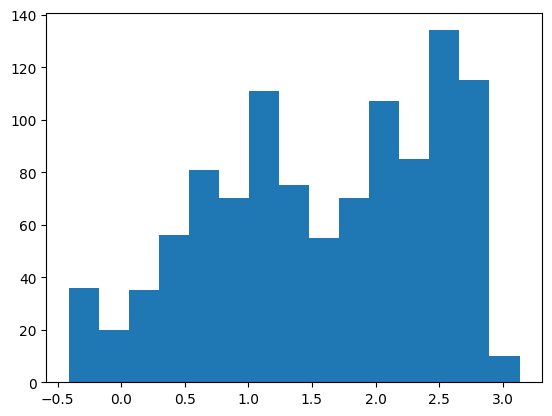

In [11]:
fin = np.array([])

for y in ys:
    fin = np.concat([fin, y])
    
plt.hist(fin, bins=15)

In [ ]:
import torch

def y_to_class(y, n_classes=3):
    bins = torch.linspace(0, 1, n_classes+1)  
    y_class = torch.bucketize(y, bins) - 1    
    y_class = torch.clamp(y_class, 0, n_classes-1)
    return y_class.long()

y_classes = [y_to_class(torch.tensor(y), n_classes=4) for y in ys]
for i in range(4):
    print(f'class "{i}" count = {y_classes[y_classes==i].shape[0]}')


class "0" count = 92
class "1" count = 92
class "2" count = 92
class "3" count = 92


In [142]:
n_classes = 4

class ClassifyingLSTM(nn.Module):
    def __init__(self, input_size=2, second_hidden=64, minute_hidden=128, n_classes=n_classes, dropout=0.5):
        super().__init__()
        self.local_lstm = nn.LSTM(input_size=input_size, hidden_size=second_hidden, batch_first=True)
        self.global_lstm = nn.LSTM(input_size=second_hidden, hidden_size=minute_hidden, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(minute_hidden, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        _, (h_sec, _) = self.local_lstm(x)
        minute_emb = h_sec[-1]
        out, _ = self.global_lstm(minute_emb.unsqueeze(0))
        logits = self.fc(out.squeeze(0))  
        return logits

model = ClassifyingLSTM()    

from sklearn.metrics import f1_score, precision_score, recall_score
def comp_metrics(y_true, y_pred):
    y_pred_class = torch.argmax(y_pred, dim=-1)
    acc = (y_pred_class == y_true).float().mean().item()

    y_true_np = y_true.numpy()
    y_pred_np = y_pred_class.numpy()

    f1 = f1_score(y_true_np, y_pred_np, average='weighted')
    precision = precision_score(y_true_np, y_pred_np, average='weighted')
    recall = recall_score(y_true_np, y_pred_np, average='weighted')
    return acc, f1, precision, recall

In [ ]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


x_list = [torch.tensor(np.expand_dims(x[:,:,0], axis=2), dtype=torch.float) for x in xs]
x_list = [torch.tensor(np.expand_dims(x[:,:,1], axis=2), dtype=torch.float) for x in xs]
x_list = [torch.tensor(np.expand_dims(x[:,:,2], axis=2), dtype=torch.float) for x in xs]
# x_list = [torch.tensor(x, dtype=torch.float) for x in xs]
# x_list = [torch.tensor(x[:,:,(0,1)], dtype=torch.float) for x in xs]

y_list = [torch.tensor(y, dtype=torch.float) for y in ys]


x_splitted = []
y_splitted = []

for x_person, y_person in zip(x_list, y_list):
    num_minutes = x_person.shape[0]
    half = num_minutes // 2

    x_chunks = [x_person[:half], x_person[half:]]
    y_chunks = [y_person[:half], y_person[half:]]

    for xc, yc in zip(x_chunks, y_chunks):
       
        if xc.shape[0] > 0:
            x_splitted.append(xc)
            y_splitted.append(yc)


x_train,  x_test, y_train, y_test = train_test_split(x_splitted, y_splitted, test_size=0.3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(500):
    total_loss = 0.
    total_acc, total_f1, total_prec, total_rec = 0.0, 0.0, 0.0, 0.0
    for x, y in zip(x_train, y_train):
        y = y_to_class(y, n_classes=n_classes)

        optimizer.zero_grad()

        y_pred = model(x)          

        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        (acc, f1, prec, rec) = comp_metrics(y, y_pred)
        total_acc += acc
        total_f1 += f1
        total_prec += prec
        total_rec += rec

    if epoch == 0 or epoch % 10 == 0:
        n = len(x_splitted)
        print(f"Epoch {epoch:02d}")
        print(f"Train metrics: | Loss={total_loss / n:.6f} | "
              f"Acc={total_acc / n:.4f} | F1={total_f1 / n:.4f} | "
              f"Prec={total_prec / n:.4f} | Rec={total_rec / n:.4f}")
        with torch.no_grad():
            total_acc, total_f1, total_prec, total_rec = 0.0, 0.0, 0.0, 0.0
            for x, y in zip(x_test, y_test):
                y = y_to_class(y, n_classes=n_classes)
                y_pred = model(x)
                (acc, f1, prec, rec) = comp_metrics(y, y_pred)
                total_acc += acc
                total_f1 += f1
                total_prec += prec
                total_rec += rec

        #     n = len(x_test)
        # print(f"Test set metrics: \t\t| MAE={avg_mae:.6f} | RMSE={avg_rmse:.6f} | R2={avg_r2:.6f}")
            print(f"Test metrics:\t\t\t| "
                  f"Acc={total_acc / n:.4f} | F1={total_f1 / n:.4f} | "
                  f"Prec={total_prec / n:.4f} | Rec={total_rec / n:.4f}")

Epoch 00
Train metrics: | Loss=0.963688 | Acc=0.2409 | F1=0.3033 | Prec=0.4920 | Rec=0.2409
Test metrics:			| Acc=0.1893 | F1=0.2048 | Prec=0.2242 | Rec=0.1893
Epoch 10
Train metrics: | Loss=0.615022 | Acc=0.5242 | F1=0.4831 | Prec=0.4527 | Rec=0.5242
Test metrics:			| Acc=0.2555 | F1=0.2362 | Prec=0.2211 | Rec=0.2555
Epoch 20
Train metrics: | Loss=0.577849 | Acc=0.5242 | F1=0.4831 | Prec=0.4527 | Rec=0.5242
Test metrics:			| Acc=0.2555 | F1=0.2362 | Prec=0.2211 | Rec=0.2555
Epoch 30
Train metrics: | Loss=0.512887 | Acc=0.5242 | F1=0.4832 | Prec=0.4527 | Rec=0.5242
Test metrics:			| Acc=0.2555 | F1=0.2362 | Prec=0.2211 | Rec=0.2555
Epoch 40
Train metrics: | Loss=0.480311 | Acc=0.5350 | F1=0.5010 | Prec=0.4824 | Rec=0.5350
Test metrics:			| Acc=0.2545 | F1=0.2357 | Prec=0.2210 | Rec=0.2545
Epoch 50
Train metrics: | Loss=0.473454 | Acc=0.5478 | F1=0.5136 | Prec=0.4862 | Rec=0.5478
Test metrics:			| Acc=0.2545 | F1=0.2357 | Prec=0.2210 | Rec=0.2545
Epoch 60
Train metrics: | Loss=0.456190 

In [115]:
x_train[1].shape

torch.Size([42, 60, 3])

In [103]:
len(x_splitted)

20

In [104]:
len(x_list)

10